In [61]:
from network.examples import community, virus
from network.simulation import rv, test, run_simulations, create_runner
from network.randoms import fix_random
from network.graph import Graph

import random
from itertools import chain
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Parameters of simulation

To start, we construct a graph based on the idea of "communities", that is, sub-groups within the graph whose members have close connections with one another. These simulate the existence of families, households, and roommates. I call these **core connections**. 

Outside of core connections exist **strong connections**, those between people of different households but still have significant interaction/time spent together. Examples of these include coworkers and friends hanging out together.

Finally, we have we **weak connections**, where people of different households engage in casual, limited contact. These include people you only briefly interact with at work, a casual conversation with a stranger, or service workers engaging with customers.

**Graph parameters**

* `n_communities` = number of communities/households
* `community_size` = household size
* `orphans` = number of single people with only outside connections
* `total_people` = total # of people in simulation, calculated by adding people in households to number of "orphans"
* `n_strong_conns` = total # of strong connections in the graph. I generally put it as some multiple of people in the simulation - for example, if each person had 3 strong connections outside their household, this would be `3 * total_people`.
* `n_weak_conns` = total # of weak connections in the graph. Similar idea as `n_strong_conns`.

**Strength parameters**

Each category of connections has an average _strength_, a measure of the likelihood of transmission across those edges. Not surprisingly, core connections would have the highest strength, followed by strong and then weak connections, based on time and closeness spent together in a closed space. These are set in `core_strength`, `strong_strength`, and `weak_strength`.

Regarding strong connections, we assume they are persistent - the people you interact closely with outside your household generally stays the same through a given period of time. For example, the coworkers and friends you interact with today, you'll likely interact with tomorrow as well. The same cannot be said for a customer at a restaurant who acts as a weak interaction for a waiter.

* `p_strong_interact` = probability on any given day any given strong interaction will recur.

With those parameters set, we can generate a base or template graph which we will use in our simulations, stored in the variable `graph0`.

In [108]:
n_communities = 800
community_size = 3
orphans = 800
total_ppl = n_communities * community_size + orphans

n_strong_conns = int(total_ppl * 1.5)
n_weak_conns = n_strong_conns

core_strength = 0.6
strong_strength = 0.4
# core_strength = 0.95
# strong_strength = 0.95
p_strong_interact = 5 / 7
weak_strength = 0.1

def generate_graph():
    graph, node_community_map = community.community_graph(
        n_communities, community_size, orphans,
        n_strong_conns, n_weak_conns,
        core_kw={'strength': core_strength}, 
        strong_kw={'strength': strong_strength}, 
        weak_kw={'strength': weak_strength}
    )
    return graph

with fix_random():
    graph0 = generate_graph()

## Vaccinate "essential workers" first (order by number of strong connections)

In [109]:
def ct_strong_edges(node):
    strong_edges = [edge for edge in graph0.outbound_edges(node) if edge.attr('kind') == 'strong']
    return len(strong_edges)

node_edge_ct = {node: ct_strong_edges(node) for node in graph0.nodes}

(array([166., 473., 717., 711., 527., 341., 155.,  76.,  23.,  11.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

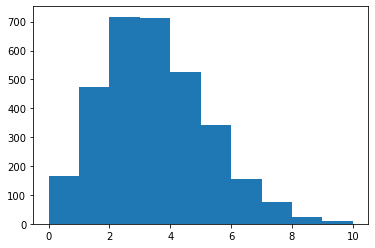

In [110]:
plt.hist(node_edge_ct.values())

In [111]:
np.mean(list(node_edge_ct.values())), np.std(list(node_edge_ct.values()))

(3.0, 1.7322312201320007)

In [112]:
def vaccination_order_by_edges(deaths):
    first_priority = []
    second_priority = []
    third_priority = []
    
    edge_ct_values = list(node_edge_ct.values())
    u = np.mean(edge_ct_values)
    sd = np.std(edge_ct_values)
    for node, strong_edge_ct in node_edge_ct.items():
        if strong_edge_ct > u + 2 * sd:
            first_priority.append(node)
        elif u + 2 * sd >= strong_edge_ct > u + sd:
            second_priority.append(node)
        else:
            third_priority.append(node)
    
    random.shuffle(first_priority)
    random.shuffle(second_priority)
    random.shuffle(third_priority)
    
    for node in chain(first_priority, second_priority, third_priority):
        if node not in deaths:
            yield node

## Vaccinate by probability of death --> elderly (strongly linked to age) first 

In [113]:
def generate_age():
    x = random.uniform(0, 1)
    if x < 0.1:
        return random.uniform(60, 70)
    elif 0.1 <= x < 0.15:
        return random.uniform(70, 80)
    elif 0.15 <= x < 0.186:
        return random.uniform(80, 90)
    else:
        return random.uniform(0, 60)

def assign_p_death(graph, max_age=90, max_p_death=0.7, decay_factor=8):
    result = {}
    for node in graph.nodes:
        age = generate_age()
        diff = max_age - age
        p_death = max_p_death * np.exp(-diff / (max_age / decay_factor))
        result[node] = p_death
    return result

p_deaths = assign_p_death(graph0)

(array([2721.,  232.,   54.,   53.,   34.,   23.,   29.,   27.,   18.,
           9.]),
 array([2.34902416e-04, 6.90961034e-02, 1.37957304e-01, 2.06818505e-01,
        2.75679706e-01, 3.44540907e-01, 4.13402108e-01, 4.82263309e-01,
        5.51124510e-01, 6.19985711e-01, 6.88846912e-01]),
 <BarContainer object of 10 artists>)

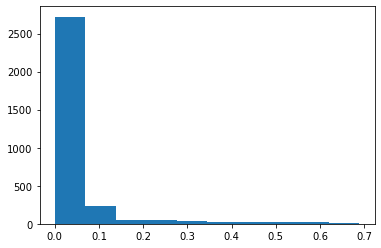

In [114]:
plt.hist(p_deaths.values())

In [133]:
np.mean(list(p_deaths.values()))

0.0431514052132774

In [115]:
def vaccination_order_by_p_death(deaths):
    first_priority = []
    second_priority = []
    third_priority = []
    for node, p_death in p_deaths.items():
        if p_death > 0.15:
            first_priority.append(node)
        elif 0.05 < p_death <= 0.15:
            second_priority.append(node)
        else:
            third_priority.append(node)
            
    random.shuffle(first_priority)
    random.shuffle(second_priority)
    random.shuffle(third_priority)
    
    for node in chain(first_priority, second_priority, third_priority):
        if node not in deaths:
            yield node

In [116]:
def reset_non_core_edges(transmission):
    graph = transmission.graph
    weak_edges_to_remove = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'weak']
    for prev_weak_edge in weak_edges_to_remove:
        graph.remove_edge(prev_weak_edge)
        
    strong_edges = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'strong']

    n_new_weak_edges = len(weak_edges_to_remove)
    for new_weak_edge in community.generate_edges(graph, n_new_weak_edges):
        graph.add_edge(new_weak_edge, kind='weak', strength=weak_strength)
        
    for edge in strong_edges:
        new_strength = strong_strength if test(p_strong_interact) else 0
        graph.update_edge(edge, strength=new_strength)
        
class _VaccineItr:
    def __init__(self, runner, transmission):
        self.transmission = transmission
        self.start_vaccine_day = runner.start_vaccine_day
        self.daily_vaccinations = runner.daily_vaccinations
        self.runner = runner
        self.rollout = runner.rollout
        
    def __next__(self):
        if self.transmission.steps >= self.start_vaccine_day:
            try:
                for _ in range(self.daily_vaccinations):
                    self.runner.vaccinated.add(next(self.rollout))
            except StopIteration:
                pass
            
        # tally deaths
        tracker = self.transmission.broadcast_tracker
        for node in tracker:
            if tracker.get(node, 9999) <= 0:
                if node not in self.runner.survived and test(p_deaths.get(node, 0)):
                    self.runner.deaths.add(node)
                else:
                    self.runner.survived.add(node)
                    
        # reset weak edges
        reset_non_core_edges(self.transmission)
        next(self.transmission)
        
        
class VaccineRunner:
    def __init__(self, rollout, start_vaccine_day, daily_vaccinations):
        self.start_vaccine_day = start_vaccine_day
        self.daily_vaccinations = daily_vaccinations
        
        self.deaths = set()
        self.survived = set()
        self.vaccinated = set()
        self.rollout = rollout(self.deaths)
        
    def __call__(self, transmission):
        return _VaccineItr(self, transmission)

In [117]:
def test_transmit(transmission, edge, vaccinated, vaccine_factor=0.05):
    edge_strength = edge.attr('strength')
    if edge.to_node in vaccinated:
        return test(edge_strength * vaccine_factor)
    return test(edge_strength)

def generate_sim(graph, runner):
    with fix_random():
        return virus.virus_simulation(
            graph=Graph.duplicate(graph),
            patient0=1,
            incubation_period=incubation_period,
            contagious_for=contagious_for,
            runner=runner,
            test_transmit=partial(test_transmit, vaccinated=runner.vaccinated)
        )

In [150]:
action_day = 50
run_to = 100
incubation_period = rv.randint(1, 10)
contagious_for = rv.choice(0, 1, 2)
daily_vaccinations = 50

# action_day = 5
# run_to = 80
# daily_vaccinations = 10
# incubation_period = rv.randint(1, 3)
# contagious_for = rv.choice(0, 1, 2)

In [152]:
control_runner = VaccineRunner(
    rollout=vaccination_order_by_p_death,
    start_vaccine_day=9999,
    daily_vaccinations=daily_vaccinations
)
control = generate_sim(graph0, control_runner)

result_control = run_simulations(
    control, to=run_to
)

In [153]:
vaccinate_elderly_first_runner = VaccineRunner(
    rollout=vaccination_order_by_p_death,
    start_vaccine_day=action_day,
    daily_vaccinations=daily_vaccinations
)
vaccinate_elderly_first = generate_sim(graph0, vaccinate_elderly_first_runner)

result_elderly = run_simulations(
    vaccinate_elderly_first,
    to=run_to
)

In [154]:
vaccinate_essential_first_runner = VaccineRunner(
    rollout=vaccination_order_by_edges,
    start_vaccine_day=action_day,
    daily_vaccinations=daily_vaccinations
)
vaccinate_essential_first = generate_sim(graph0, vaccinate_essential_first_runner)

result_essential = run_simulations(
    vaccinate_essential_first,
    to=run_to
)

In [155]:
len(control_runner.deaths), len(vaccinate_elderly_first_runner.deaths), len(vaccinate_essential_first_runner.deaths)

(122, 64, 111)

In [156]:
def sim_sequence(sim, n):
    for i in range(n):
        index = -1 if i >= len(sim.history) else i
        yield sim.history[index].broadcasts

def plot(results, labels=None):
    fig = plt.figure(figsize=(12, 12))
    plt.title('Virus transmission vs. T (days)', fontsize=16)
    lines = []
    for sim in results:
        line, = plt.plot(range(run_to), list(sim_sequence(sim, run_to)), 'o-')
        lines.append(line)

    if labels:
        plt.legend(lines, labels, loc='upper left')
    plt.xlabel('Days elapsed')
    plt.ylabel('Cases')

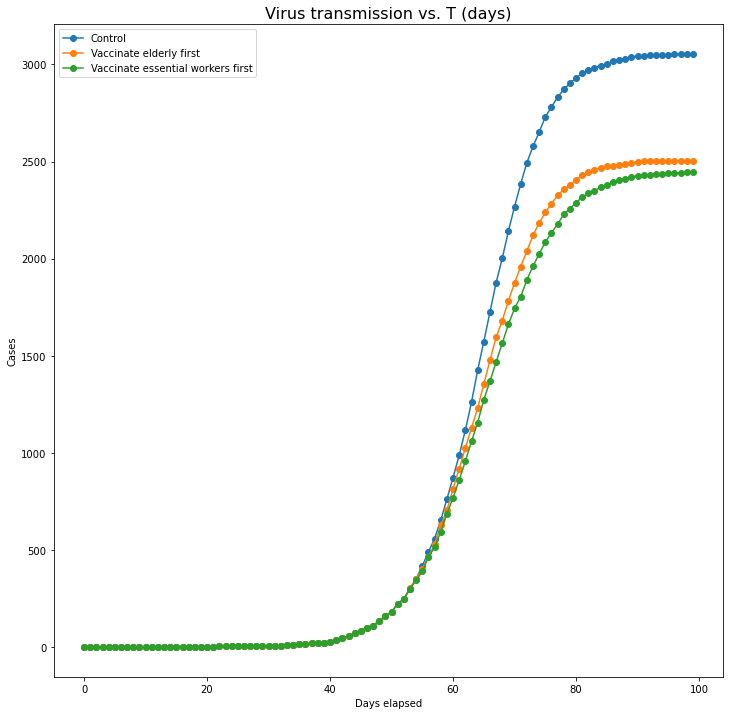

In [157]:
plot(
    [control, result_elderly, result_essential],
    ['Control', 'Vaccinate elderly first', 'Vaccinate essential workers first']
)